In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline

from calidhayte.calibrate import Calibrate

import shap
import matplotlib.pyplot as plt

plt.style.use('bmh')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
np.random.seed(4)
x_df = pd.DataFrame()
x_df['x'] = pd.Series(np.random.rand(300))
x_df['a'] = pd.Series(np.random.rand(300))
x_df['b'] = pd.Series(np.random.rand(300))
x_df['c'] = pd.Series(np.random.rand(300))
coeffs = np.random.randn(4)

y_df = pd.DataFrame()
modded = x_df * coeffs

y_df['x'] = modded.sum(axis=1)
y_df['Fold'] = ([0]*60) + ([1]*60) + ([2]*60) + ([3]*60) + ([4]*60)

cal = Calibrate(
        x_df,
        y_df,
        target='x'
        )
cal.linreg()
cal.theil_sen()
cal.random_forest()

models = cal.return_models()

The least populated class in y has only 2 members, which is less than n_splits=5.


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

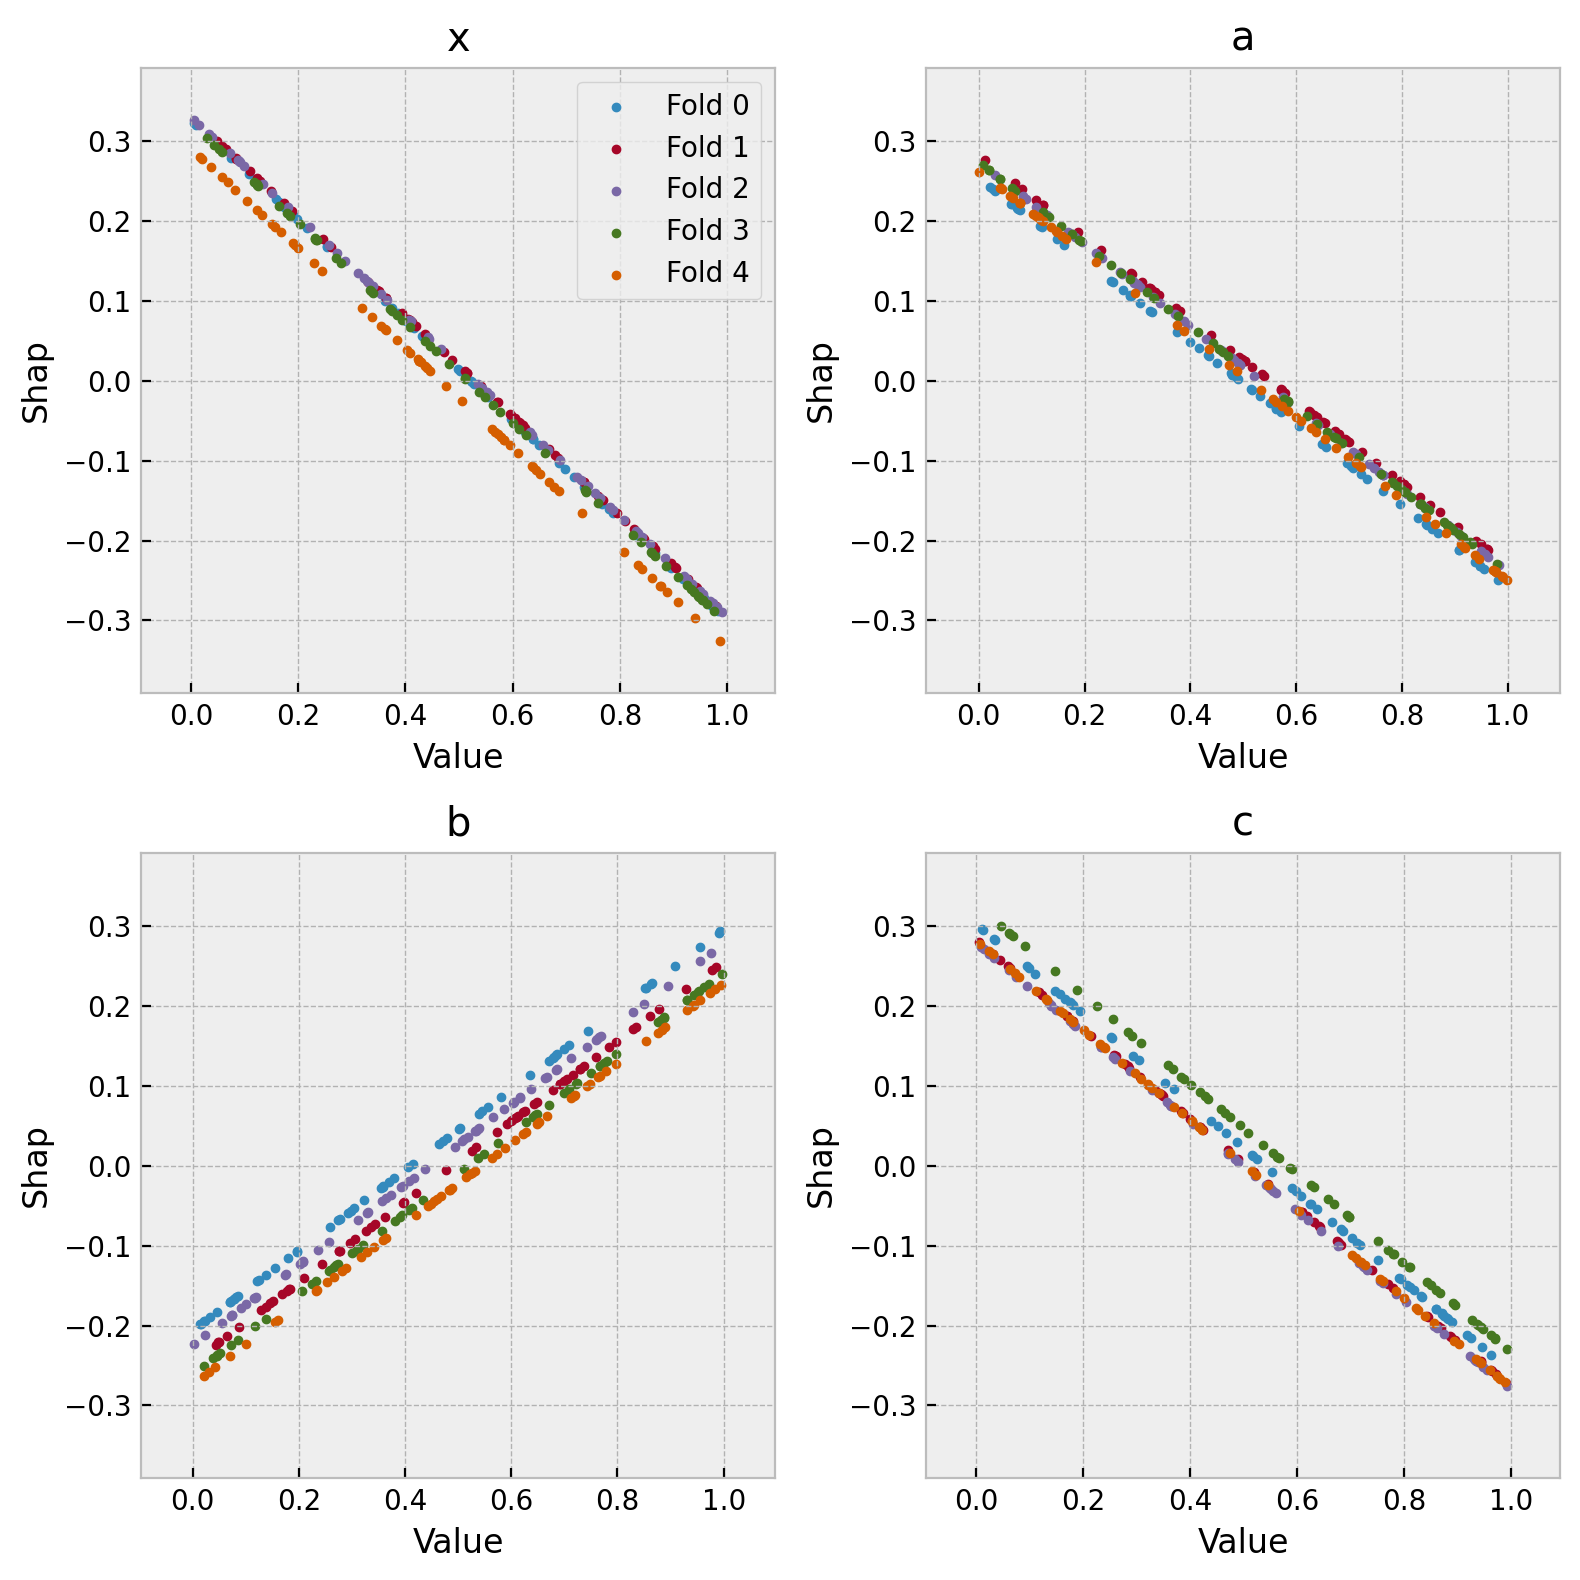

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

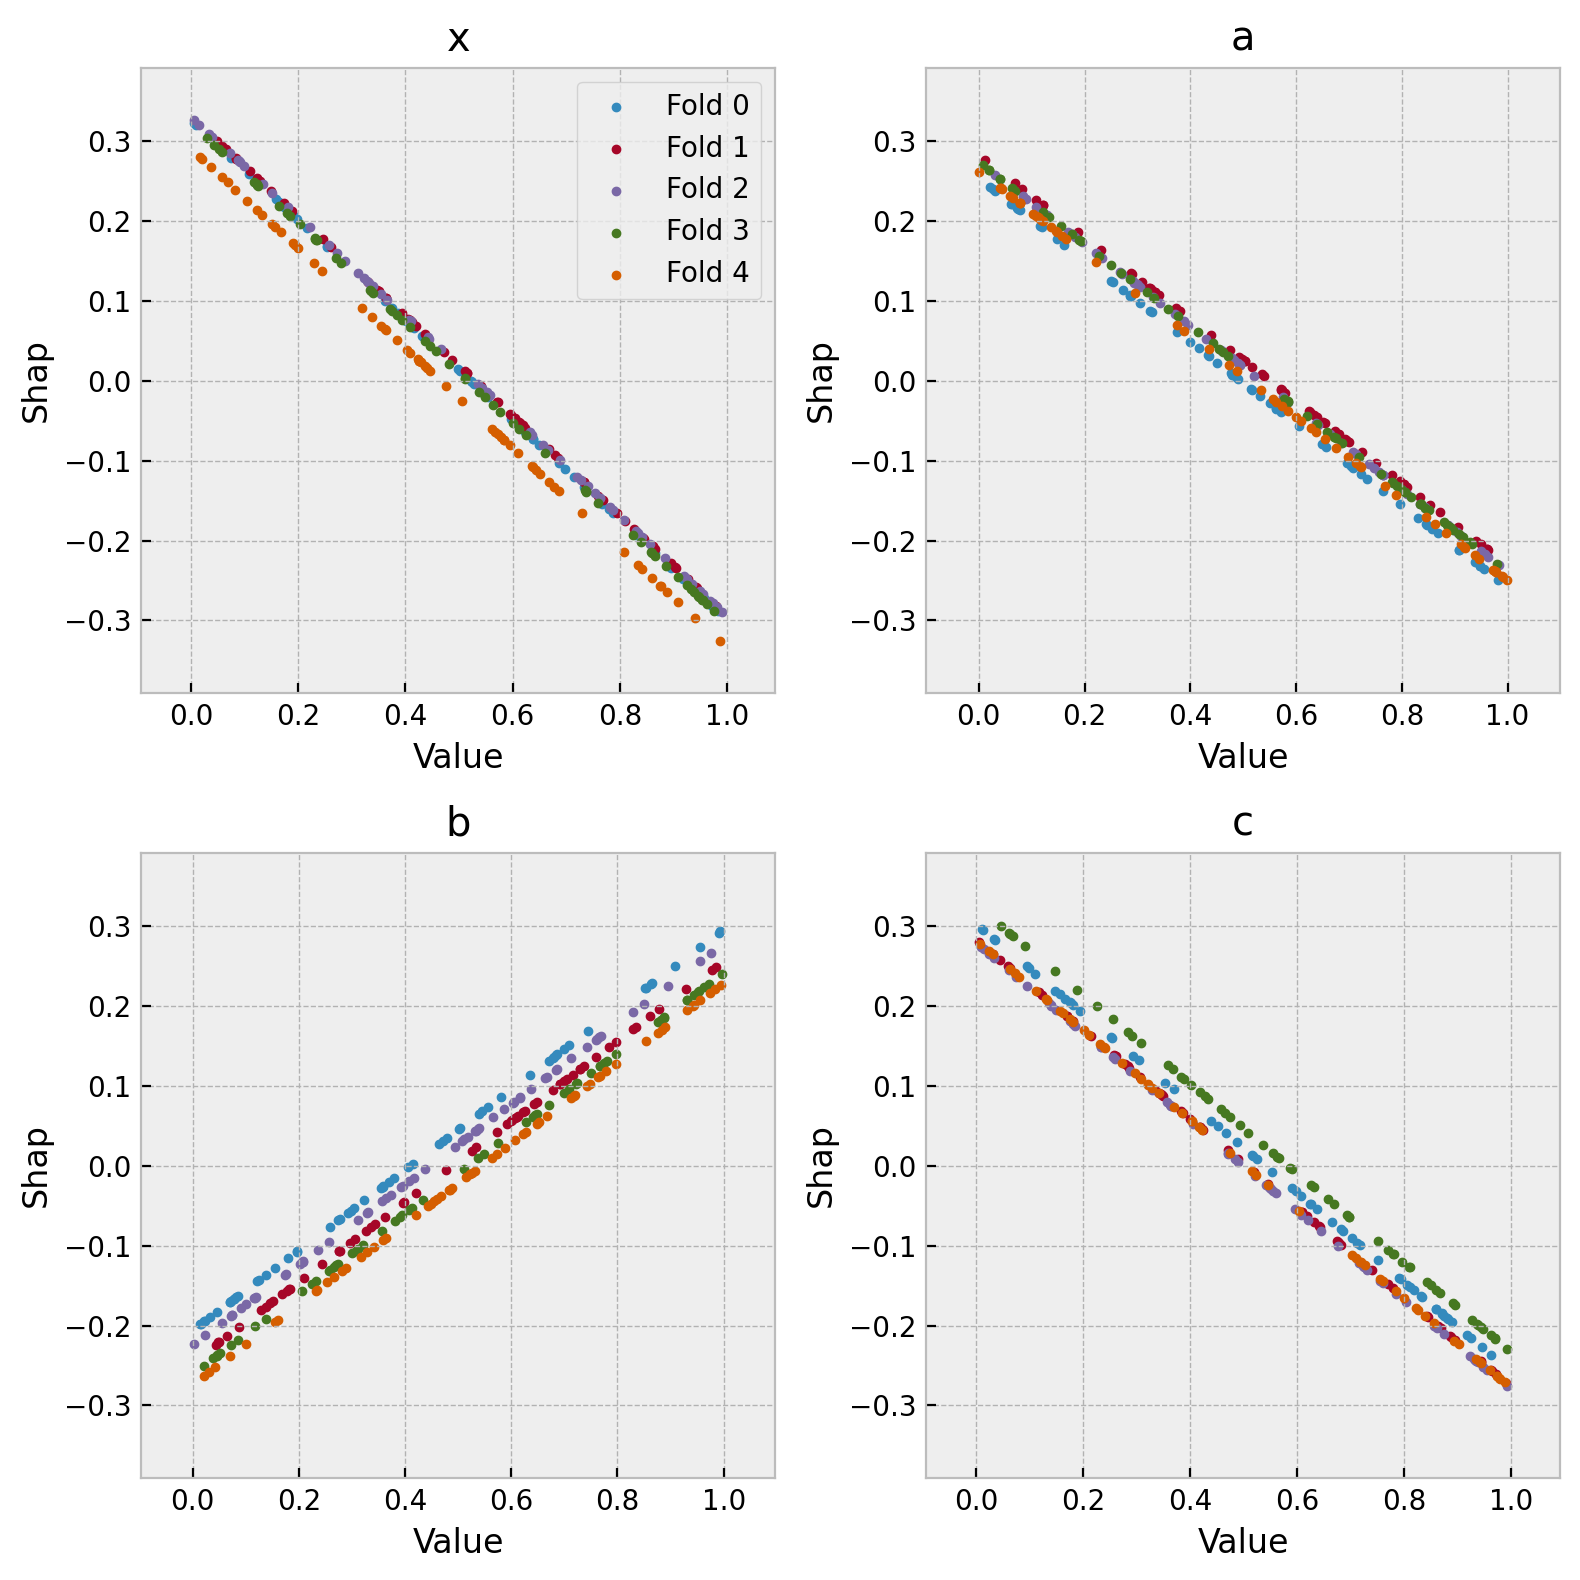

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

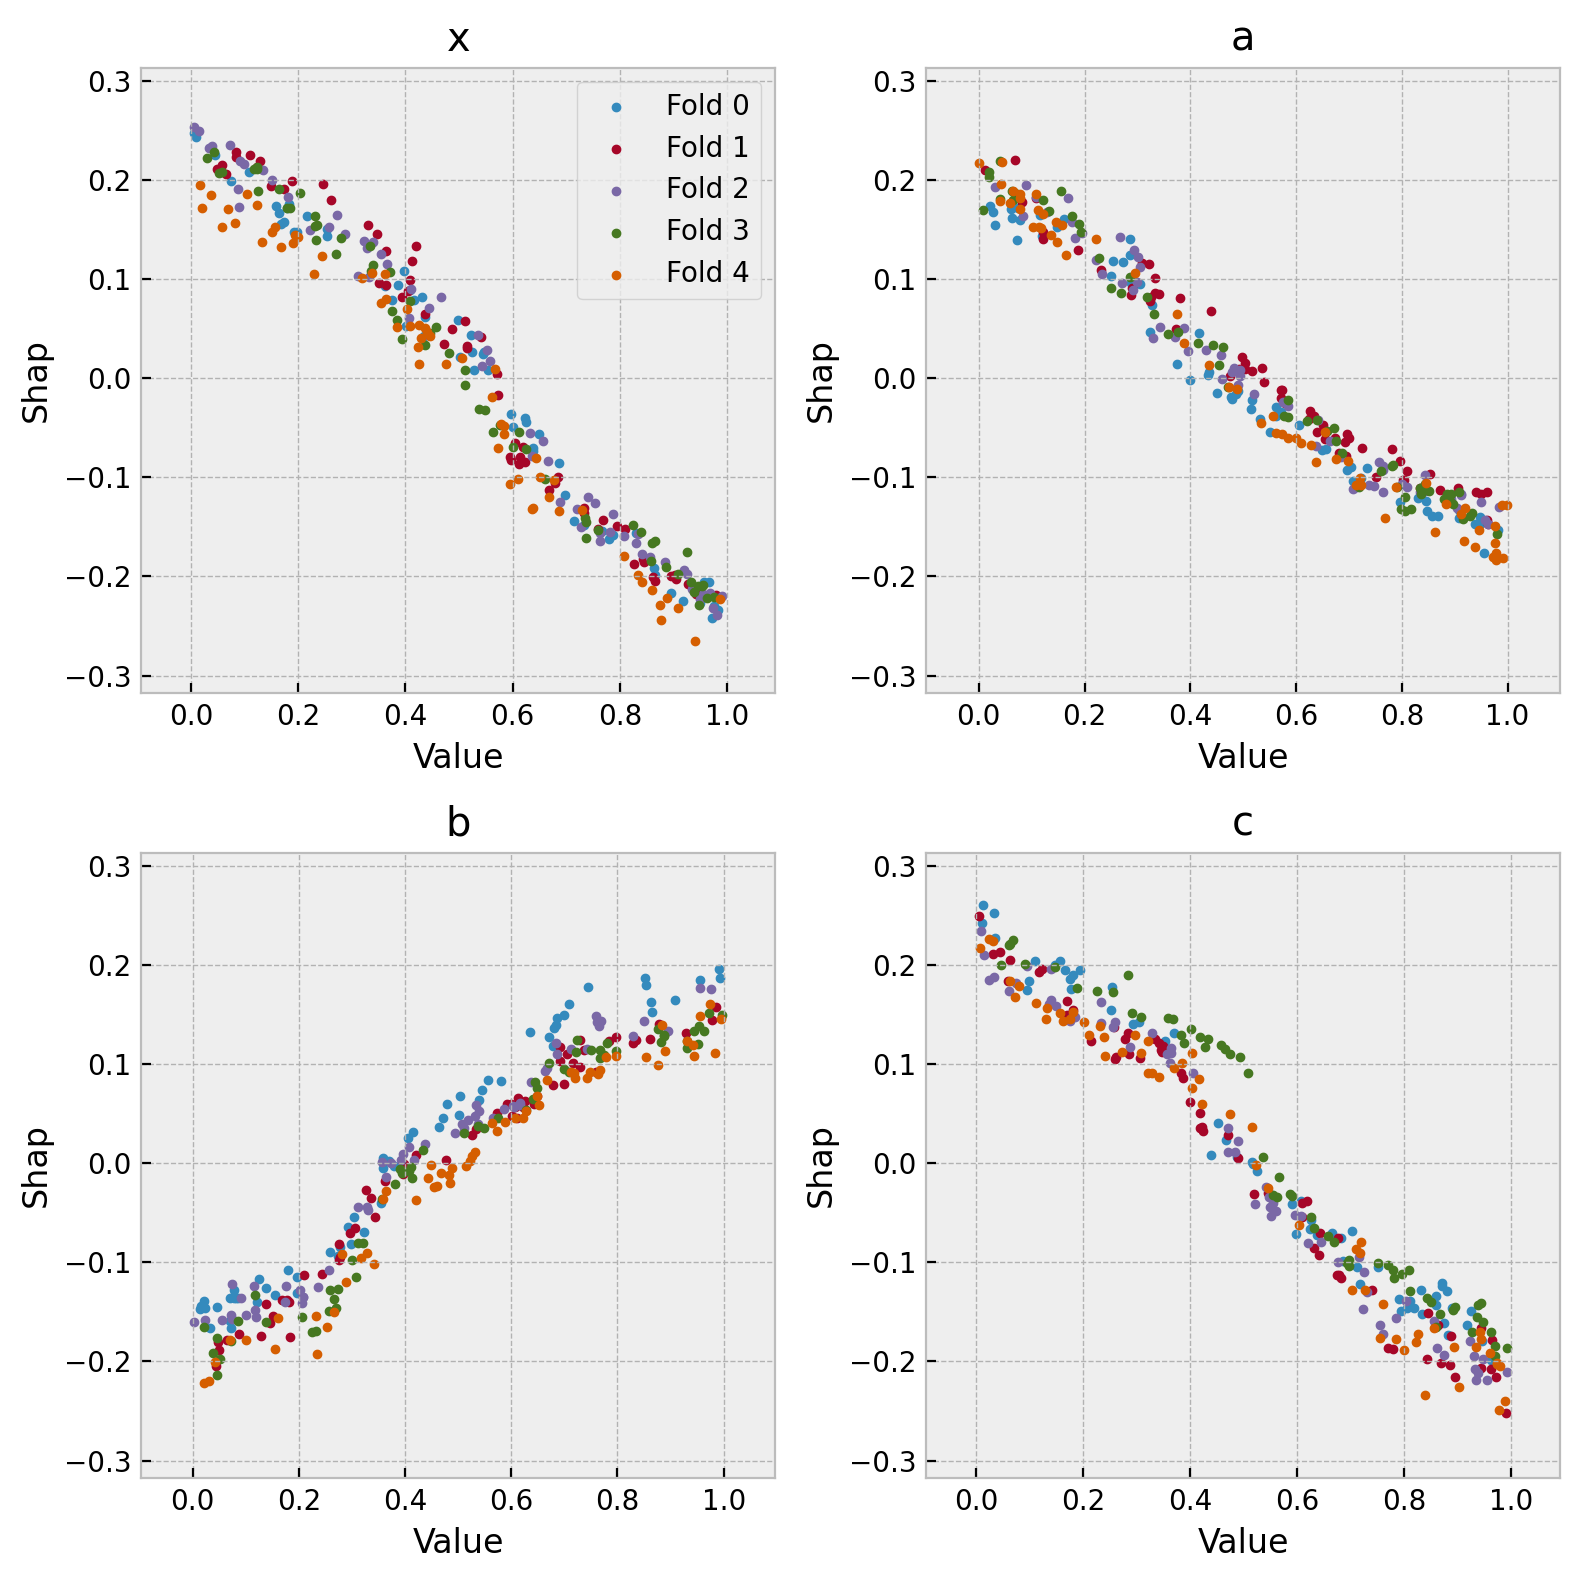

In [3]:
def get_shap(x, y, pipeline):
    shaps = pd.DataFrame()
    for fold in pipeline.keys():
        fold_index = y[y.loc[:, 'Fold'] == fold].index
        x_data = x.loc[fold_index, :]
        explainer = shap.KernelExplainer(
            model=pipeline[fold][-1].predict,
            data=x_data,
            link='identity'
        )
        shaps = pd.concat(
            [
                shaps,
                pd.DataFrame(
                    explainer.shap_values(x_data),
                    index=x_data.index,
                    columns=x_data.columns
                )
            ]
        )
    shaps.loc[y.index, 'Fold'] = y.loc[:, 'Fold']
    shaps = shaps.sort_index()

    shaps_min = shaps.drop(['Fold'], axis=1).min(axis=None)
    shaps_max = shaps.drop(['Fold'], axis=1).max(axis=None)
    shaps_range = shaps_max - shaps_min
    shaps_lims = (
        shaps_min - (shaps_range * 0.1),
        shaps_max + (shaps_range * 0.1)
    )

    num_of_cols = shaps.drop(['Fold'], axis=1).shape[1]

    shape_of_scatters = (
        int(np.ceil(num_of_cols / 2)),
        (min(2, int(num_of_cols)))
    )

    fig, ax = plt.subplots(
        *shape_of_scatters,
        figsize=(
           4 * shape_of_scatters[0],
           4 * shape_of_scatters[1]
        ),
        dpi=200
    )

    for col_ind, col in enumerate(shaps.drop(['Fold'], axis=1).columns):
        scatter_data = pd.concat(
            [
                x.loc[:, col].rename('Value'),
                shaps.loc[:, col].rename('Shap'),
                shaps.loc[:, 'Fold'].rename('Fold')
            ],
            axis=1
        )
        x_min = scatter_data.loc[:, 'Value'].min()
        x_max = scatter_data.loc[:, 'Value'].max()
        x_range = x_max - x_min
        x_lims = (x_min - (x_range * 0.1), x_max + (x_range * 0.1))

        row_num = int(np.floor(col_ind / 2))
        col_num = col_ind % 2
        for fold in shaps.loc[:, 'Fold'].unique():
            scat_fold = scatter_data[scatter_data.loc[:, 'Fold'] == fold]
            ax[row_num, col_num].scatter(
                scat_fold['Value'],
                scat_fold['Shap'],
                c=f'C{int(fold)}',
                label=f'Fold {int(fold)}',
                marker='.'
            )
        ax[row_num, col_num].set_title(col)
        ax[row_num, col_num].set_xlabel('Value')
        ax[row_num, col_num].set_xlim(x_lims)
        ax[row_num, col_num].set_ylabel('Shap')
        ax[row_num, col_num].set_ylim(shaps_lims)

    ax[0, 0].legend(loc='best')
    plt.tight_layout()
    plt.show()

    return shaps


for key in models.keys():
    shapley = get_shap(x_df, y_df, models[key]['None']['x + a + b + c'])


[This is a link](https://uhoh)